<a href="https://colab.research.google.com/github/serkansokmen/ml-workspace/blob/master/ML_Course_Siraj_Week_03_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fraud Detection

Tasks:
- Explore the dataset / visualize
- Decide which features are important
- Create model
- Validate model



In [0]:
import numpy as np
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import multiprocessing
import seaborn as sns
import lightgbm as lgb


from sklearn.preprocessing import scale
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, KFold

warnings.simplefilter('ignore')
sns.set()
%matplotlib inline

## Prepare / preprocess data

In [0]:
from google.colab import files
files.upload()

{}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
mount_path = '/content/drive/My Drive/ML_Course_Siraj/Week_03'
%mkdir -p '/content/drive/My Drive/ML_Course_Siraj/Week_03'
%cd '/content/drive/My Drive/ML_Course_Siraj/Week_03'
%pwd

/content/drive/My Drive/ML_Course_Siraj/Week_03


'/content/drive/My Drive/ML_Course_Siraj/Week_03'

In [0]:
!kaggle competitions download -c ieee-fraud-detection

 93% 49.0M/52.5M [00:00<00:00, 44.8MB/s]
100% 52.5M/52.5M [00:00<00:00, 63.7MB/s]
  0% 0.00/3.02M [00:00<?, ?B/s]
100% 3.02M/3.02M [00:00<00:00, 99.3MB/s]
 87% 41.0M/47.3M [00:00<00:00, 42.5MB/s]
100% 47.3M/47.3M [00:00<00:00, 69.4MB/s]
  0% 0.00/2.97M [00:00<?, ?B/s]
100% 2.97M/2.97M [00:00<00:00, 97.7MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 75.9MB/s]


In [0]:
!unzip train_identity.csv.zip; rm -rf train_identity.csv.zip
!unzip train_transaction.csv.zip; rm -rf train_transaction.csv.zip
!unzip test_identity.csv.zip; rm -rf test_identity.csv.zip
!unzip test_transaction.csv.zip; rm -rf test_transaction.csv.zip
!unzip sample_submission.csv.zip; rm -rf sample_submission.csv.zip

!chmod 644 train_identity.csv
!chmod 644 train_transaction.csv
!chmod 644 test_identity.csv
!chmod 644 test_transaction.csv
!chmod 644 sample_submission.csv

%mkdir -p ieee-fraud-detection
!mv *.csv ieee-fraud-detection

unzip:  cannot find or open train_identity.csv.zip, train_identity.csv.zip.zip or train_identity.csv.zip.ZIP.
unzip:  cannot find or open train_transaction.csv.zip, train_transaction.csv.zip.zip or train_transaction.csv.zip.ZIP.
unzip:  cannot find or open test_identity.csv.zip, test_identity.csv.zip.zip or test_identity.csv.zip.ZIP.
unzip:  cannot find or open test_transaction.csv.zip, test_transaction.csv.zip.zip or test_transaction.csv.zip.ZIP.
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'
                      .format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
%%time
warnings.simplefilter('ignore')
files = ['ieee-fraud-detection/test_identity.csv', 
         'ieee-fraud-detection/test_transaction.csv',
         'ieee-fraud-detection/train_identity.csv',
         'ieee-fraud-detection/train_transaction.csv',
         'ieee-fraud-detection/sample_submission.csv']

def load_data(file):
    return reduce_mem_usage(pd.read_csv(f'{mount_path}/{file}'))

with multiprocessing.Pool() as pool:
    test_identity, test_transaction, train_identity, train_transaction, sample_submission = pool.map(load_data, files)

Mem. usage decreased to 25.44 Mb (42.7% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to  2.90 Mb (62.5% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)
Mem. usage decreased to 542.35 Mb (69.4% reduction)
CPU times: user 1.96 s, sys: 1.34 s, total: 3.3 s
Wall time: 2min 18s


## Visualize data

Credits to Leonardo's Kernel: 
https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt

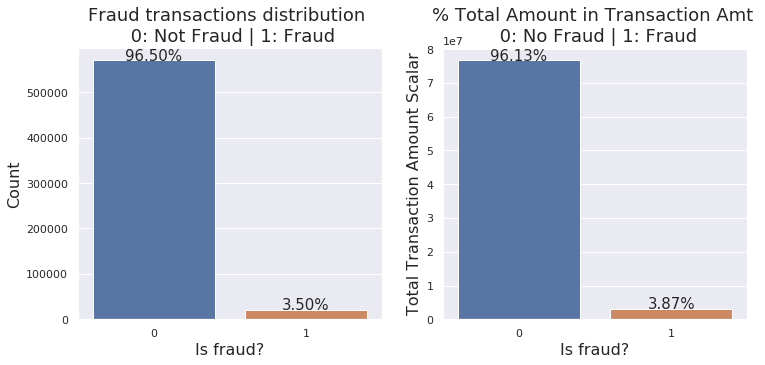

In [0]:
train_transaction['TransactionAmt'] = train_transaction['TransactionAmt'].astype(float)
total = len(train_transaction)
total_amt = train_transaction.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize=(12,5))

plt.subplot(121)
plot_tr = sns.countplot(x='isFraud', data=train_transaction)
plot_tr.set_title('Fraud transactions distribution \n 0: Not Fraud | 1: Fraud', 
                  fontsize=18)
plot_tr.set_xlabel('Is fraud?', fontsize=16)
plot_tr.set_ylabel('Count', fontsize=16)
for p in plot_tr.patches:
  height = p.get_height()
  plot_tr.text(p.get_x()+p.get_width()/2.,
               height + 3,
               '{:1.2f}%'.format(height/total*100),
               ha='center', fontsize=15)

percent_amt = (train_transaction.groupby(['isFraud'])['TransactionAmt'].sum())
percent_amt = percent_amt.reset_index()
plt.subplot(122)
plot_tr_2 = sns.barplot(x='isFraud', y='TransactionAmt',  dodge=True, data=percent_amt)
plot_tr_2.set_title("% Total Amount in Transaction Amt \n 0: No Fraud | 1: Fraud", fontsize=18)
plot_tr_2.set_xlabel('Is fraud?', fontsize=16)
plot_tr_2.set_ylabel('Total Transaction Amount Scalar', fontsize=16)
for p in plot_tr_2.patches:
  height = p.get_height()
  plot_tr_2.text(p.get_x()+p.get_width()/2.,
                 height + 3,
                 '{:1.2f}%'.format(height/total_amt * 100),
                 ha='center', fontsize=15)

Transaction Amount Values Distribution

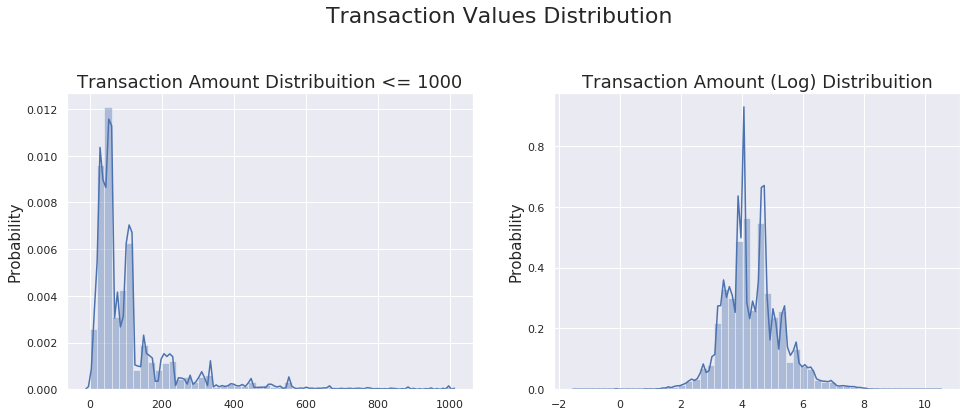

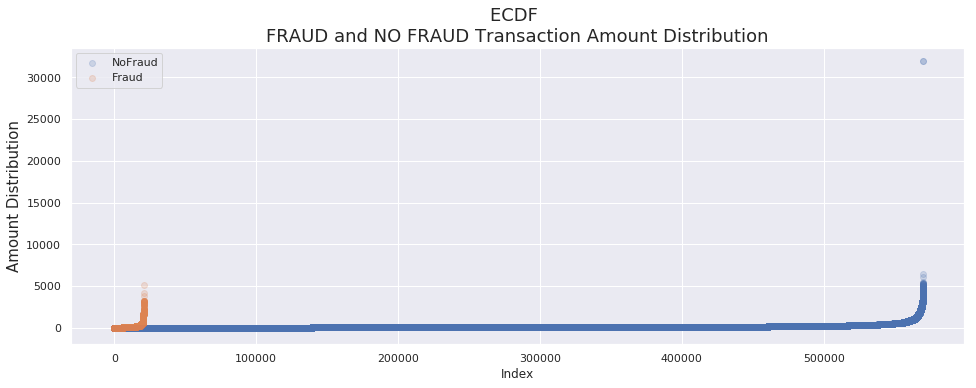

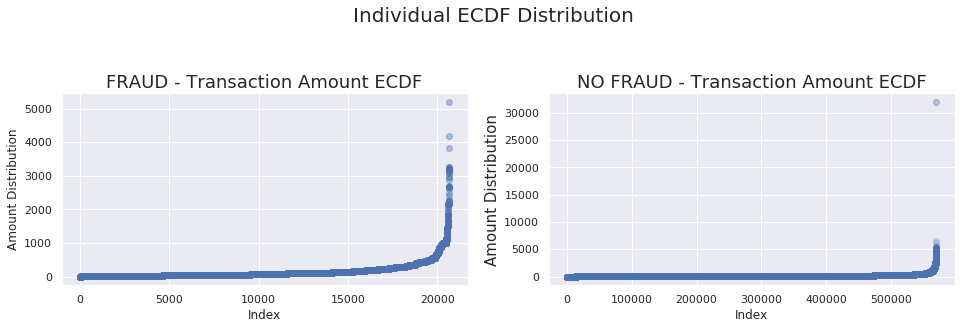

In [0]:
plt.figure(figsize=(16, 12))
plt.suptitle('Transaction Values Distribution', fontsize=22)
plt.subplot(221)
sub_plot_1 = sns.distplot(train_transaction[train_transaction['TransactionAmt'] <= 1000]['TransactionAmt'])
sub_plot_1.set_title("Transaction Amount Distribuition <= 1000", fontsize=18)
sub_plot_1.set_xlabel("")
sub_plot_1.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
sub_plot_2 = sns.distplot(np.log(train_transaction['TransactionAmt']))
sub_plot_2.set_title("Transaction Amount (Log) Distribuition", fontsize=18)
sub_plot_2.set_xlabel("")
sub_plot_2.set_ylabel("Probability", fontsize=15)

plt.figure(figsize=(16, 12))


plt.subplot(212)
sub_plot_3 = plt.scatter(range(train_transaction[train_transaction['isFraud'] == 0].shape[0]),
                         np.sort(train_transaction[train_transaction['isFraud'] == 0]['TransactionAmt'].values),
                         label='NoFraud', alpha=.2)
sub_plot_3 = plt.scatter(range(train_transaction[train_transaction['isFraud'] == 1].shape[0]),
                         np.sort(train_transaction[train_transaction['isFraud'] == 1]['TransactionAmt'].values),
                         label='Fraud', alpha=.2)
sub_plot_3 = plt.title("ECDF \nFRAUD and NO FRAUD Transaction Amount Distribution", fontsize=18)
sub_plot_3 = plt.xlabel("Index")
sub_plot_3 = plt.ylabel("Amount Distribution", fontsize=15)
sub_plot_3 = plt.legend()

plt.figure(figsize=(16, 12))

plt.subplot(321)
sub_plot_4 = plt.scatter(range(train_transaction[train_transaction['isFraud'] == 1].shape[0]),
                         np.sort(train_transaction[train_transaction['isFraud'] == 1]['TransactionAmt'].values),
                         label='isFraud', alpha=.4)
plt.title("FRAUD - Transaction Amount ECDF", fontsize=18)
plt.xlabel("Index")
plt.ylabel("Amount Distribution", fontsize=12)

plt.subplot(322)
sub_plot_5 = plt.scatter(range(train_transaction[train_transaction['isFraud'] == 0].shape[0]),
                         np.sort(train_transaction[train_transaction['isFraud'] == 0]['TransactionAmt'].values),
                         label='NoFraud', alpha=.2)
sub_plot_5 = plt.title("NO FRAUD - Transaction Amount ECDF", fontsize=18)
sub_plot_5 = plt.xlabel("Index")
sub_plot_5 = plt.ylabel("Amount Distribution", fontsize=15)

plt.suptitle('Individual ECDF Distribution', fontsize=20)

plt.show()


The Product Feature

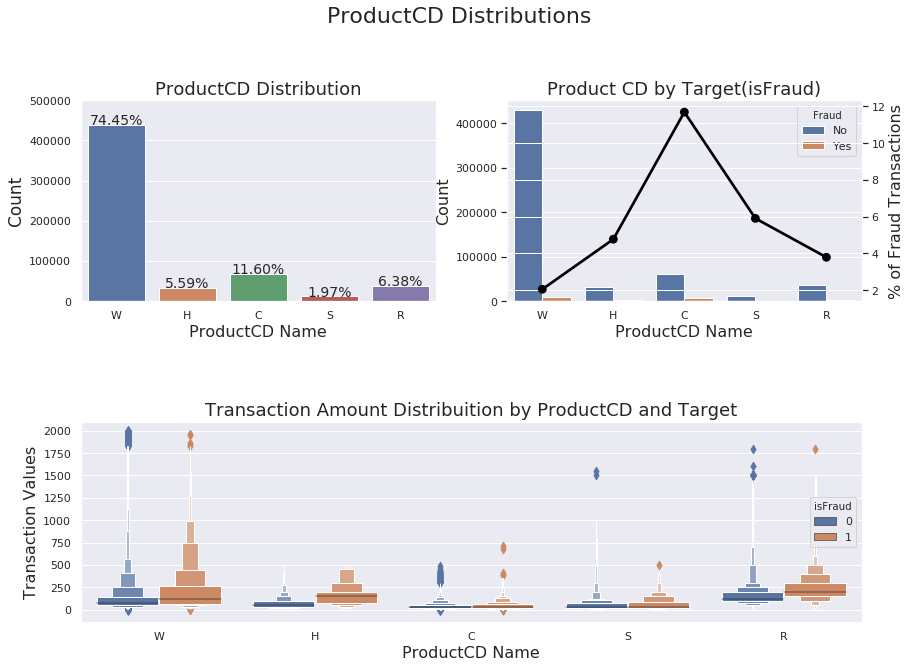

In [0]:
tmp = pd.crosstab(train_transaction['ProductCD'], train_transaction['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('ProductCD Distributions', fontsize=22)

plt.subplot(221)
plot_1 = sns.countplot(x='ProductCD', data=train_transaction)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

plot_1.set_title("ProductCD Distribution", fontsize=18)
plot_1.set_xlabel("ProductCD Name", fontsize=16)
plot_1.set_ylabel("Count", fontsize=17)
plot_1.set_ylim(0,500000)
for p in plot_1.patches:
    height = p.get_height()
    plot_1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(222)
plot_2 = sns.countplot(x='ProductCD', hue='isFraud', data=train_transaction)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
plot_2_2 = plot_2.twinx()
plot_2_2 = sns.pointplot(x='ProductCD', y='Fraud', data=tmp, color='black', order=['W', 'H',"C", "S", "R"], legend=False)
plot_2_2.set_ylabel("% of Fraud Transactions", fontsize=16)

plot_2.set_title("Product CD by Target(isFraud)", fontsize=18)
plot_2.set_xlabel("ProductCD Name", fontsize=16)
plot_2.set_ylabel("Count", fontsize=16)

plt.subplot(212)
plot_3 = sns.boxenplot(x='ProductCD', y='TransactionAmt', hue='isFraud', 
              data=train_transaction[train_transaction['TransactionAmt'] <= 2000] )
plot_3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=18)
plot_3.set_xlabel("ProductCD Name", fontsize=16)
plot_3.set_ylabel("Transaction Values", fontsize=16)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

Visualizing Card 1, Card 2 and Card 3 Distributions

In [0]:
train_transaction.loc[train_transaction.card3.isin(
    train_transaction.card3.value_counts()[
        train_transaction.card3.value_counts() < 200].index), 'card3'] = "Others"
train_transaction.loc[train_transaction.card5.isin(
    train_transaction.card5.value_counts()[
        train_transaction.card5.value_counts() < 300].index), 'card5'] = "Others"

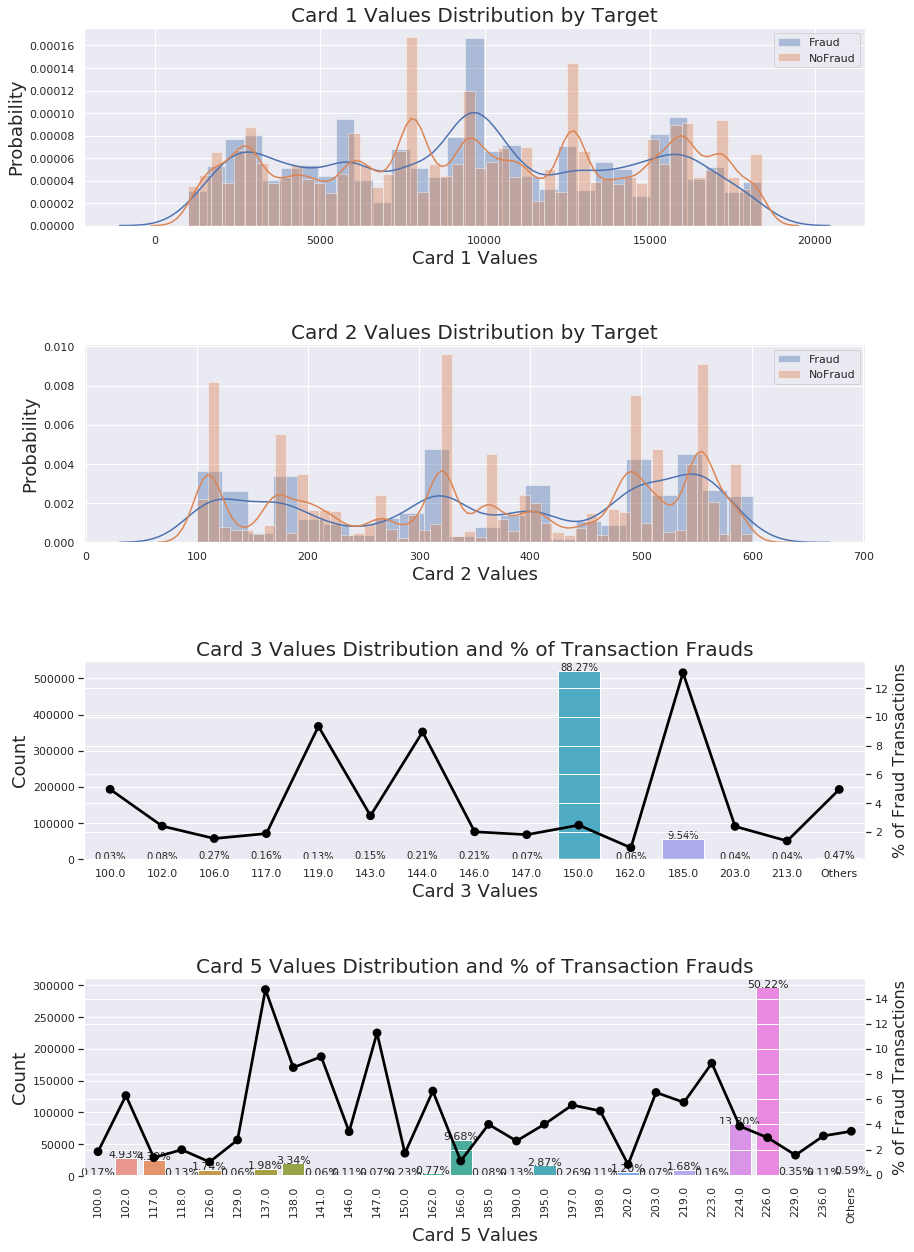

In [0]:
tmp = pd.crosstab(train_transaction['card3'], train_transaction['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

tmp2 = pd.crosstab(train_transaction['card5'], train_transaction['isFraud'], normalize='index') * 100
tmp2 = tmp2.reset_index()
tmp2.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,22))

plt.subplot(411)
plot_1 = sns.distplot(train_transaction[train_transaction['isFraud'] == 1]['card1'], label='Fraud')
plot_1 = sns.distplot(train_transaction[train_transaction['isFraud'] == 0]['card1'], label='NoFraud')
plot_1.legend()
plot_1.set_title("Card 1 Values Distribution by Target", fontsize=20)
plot_1.set_xlabel("Card 1 Values", fontsize=18)
plot_1.set_ylabel("Probability", fontsize=18)

plt.subplot(412)
plot_2 = sns.distplot(train_transaction[train_transaction['isFraud'] == 1]['card2'].dropna(), label='Fraud')
plot_2 = sns.distplot(train_transaction[train_transaction['isFraud'] == 0]['card2'].dropna(), label='NoFraud')
plot_2.legend()
plot_2.set_title("Card 2 Values Distribution by Target", fontsize=20)
plot_2.set_xlabel("Card 2 Values", fontsize=18)
plot_2.set_ylabel("Probability", fontsize=18)

plt.subplot(413)
plot_3 = sns.countplot(x='card3', data=train_transaction, order=list(tmp.card3.values))
plot_3_2 = plot_3.twinx()
plot_3_2 = sns.pointplot(x='card3', y='Fraud', data=tmp, 
                    color='black', order=list(tmp.card3.values))
plot_3_2.set_ylabel("% of Fraud Transactions", fontsize=16)
plot_3.set_title("Card 3 Values Distribution and % of Transaction Frauds", fontsize=20)
plot_3.set_xlabel("Card 3 Values", fontsize=18)
plot_3.set_ylabel("Count", fontsize=18)
for p in plot_3.patches:
    height = p.get_height()
    plot_3.text(p.get_x()+p.get_width()/2.,
            height + 25,
            '{:1.2f}%'.format(height/total*100),
            ha="center") 

plt.subplot(414)
plot_4 = sns.countplot(x='card5', data=train_transaction, order=list(tmp2.card5.values))
plot_4_2 = plot_4.twinx()
plot_4_2 = sns.pointplot(x='card5', y='Fraud', data=tmp2, 
                    color='black', order=list(tmp2.card5.values))
plot_4_2.set_ylabel("% of Fraud Transactions", fontsize=16)
plot_4.set_title("Card 5 Values Distribution and % of Transaction Frauds", fontsize=20)
plot_4.set_xticklabels(plot_4.get_xticklabels(),rotation=90)
plot_4.set_xlabel("Card 5 Values", fontsize=18)
plot_4.set_ylabel("Count", fontsize=18)
for p in plot_4.patches:
    height = p.get_height()
    plot_4.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=11) 
    
plt.subplots_adjust(hspace = 0.6, top = 0.85)


plt.show()

Card 4 - Categorical Feature

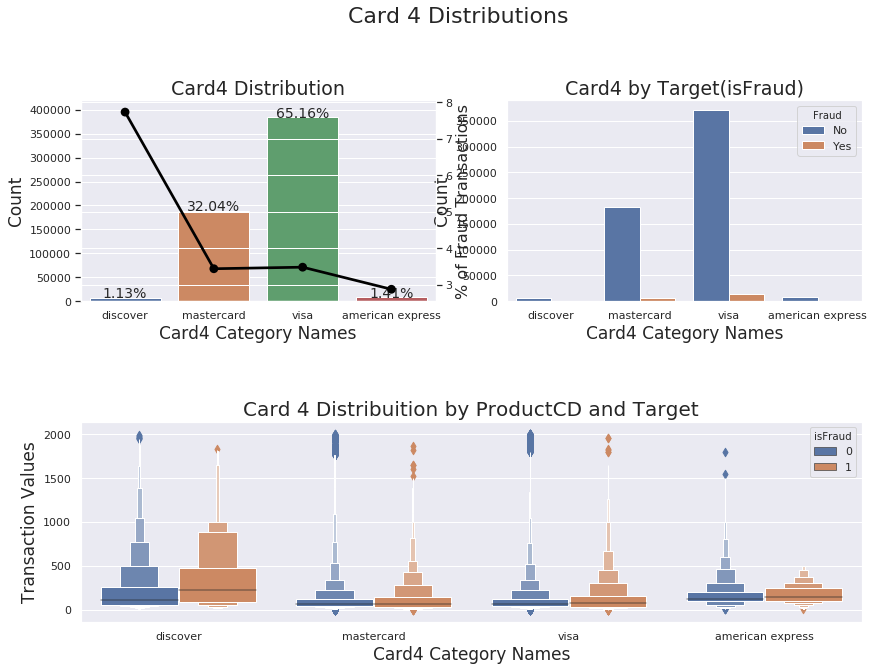

In [0]:
tmp = pd.crosstab(train_transaction['card4'], train_transaction['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 4 Distributions', fontsize=22)

plt.subplot(221)
plot_1 = sns.countplot(x='card4', data=train_transaction)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
plot_1.set_title("Card4 Distribution", fontsize=19)
plot_1.set_ylim(0,420000)
plot_1.set_xlabel("Card4 Category Names", fontsize=17)
plot_1.set_ylabel("Count", fontsize=17)
for p in plot_1.patches:
    height = p.get_height()
    plot_1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 


plt.subplot(222)
plot_2 = sns.countplot(x='card4', hue='isFraud', data=train_transaction)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
plot_2_2 = plot_1.twinx()
plot_2_2 = sns.pointplot(x='card4', y='Fraud', data=tmp, 
                   color='black', legend=False, 
                   order=['discover', 'mastercard', 'visa', 'american express'])
plot_2_2.set_ylabel("% of Fraud Transactions", fontsize=16)
plot_2.set_title("Card4 by Target(isFraud)", fontsize=19)
plot_2.set_xlabel("Card4 Category Names", fontsize=17)
plot_2.set_ylabel("Count", fontsize=17)

plt.subplot(212)
plot_3 = sns.boxenplot(x='card4', y='TransactionAmt', hue='isFraud', 
              data=train_transaction[train_transaction['TransactionAmt'] <= 2000] )
plot_3.set_title("Card 4 Distribuition by ProductCD and Target", fontsize=20)
plot_3.set_xlabel("Card4 Category Names", fontsize=17)
plot_3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

Card 6 - Categorical

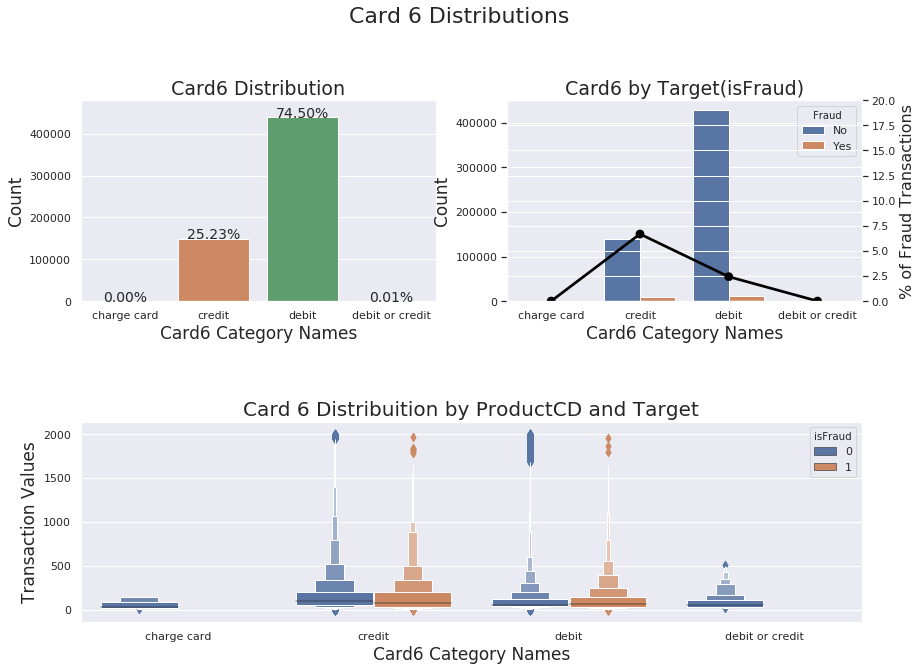

In [0]:
tmp = pd.crosstab(train_transaction['card6'], train_transaction['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 6 Distributions', fontsize=22)

plt.subplot(221)
plot_1 = sns.countplot(x='card6', data=train_transaction, order=list(tmp.card6.values))
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
plot_1.set_title("Card6 Distribution", fontsize=19)
plot_1.set_ylim(0,480000)
plot_1.set_xlabel("Card6 Category Names", fontsize=17)
plot_1.set_ylabel("Count", fontsize=17)
for p in plot_1.patches:
    height = p.get_height()
    plot_1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 

plt.subplot(222)
plot_2 = sns.countplot(x='card6', hue='isFraud', data=train_transaction, order=list(tmp.card6.values))
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
plot_2_2 = plot_2.twinx()
plot_2_2 = sns.pointplot(x='card6', y='Fraud', data=tmp, order=list(tmp.card6.values),
                   color='black', legend=False, )
plot_2_2.set_ylim(0,20)
plot_2_2.set_ylabel("% of Fraud Transactions", fontsize=16)
plot_2.set_title("Card6 by Target(isFraud)", fontsize=19)
plot_2.set_xlabel("Card6 Category Names", fontsize=17)
plot_2.set_ylabel("Count", fontsize=17)

plt.subplot(212)
plot_3 = sns.boxenplot(x='card6', y='TransactionAmt', hue='isFraud', order=list(tmp.card6.values),
              data=train_transaction[train_transaction['TransactionAmt'] <= 2000] )
plot_3.set_title("Card 6 Distribuition by ProductCD and Target", fontsize=20)
plot_3.set_xlabel("Card6 Category Names", fontsize=17)
plot_3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

Exploring M1-M9 Features

In [0]:
for columns in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    train_transaction[columns] = train_transaction[columns].fillna("Miss")
    
def ploting_dist_ratio(DataFile, Column, lim=2000):
    tmp = pd.crosstab(DataFile[Column], DataFile['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.figure(figsize=(20,5))
    plt.suptitle(f'{Column} Distributions ', fontsize=22)

    plt.subplot(121)
    plot_1 = sns.countplot(x=Column, data=DataFile, order=list(tmp[Column].values))
    # plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
    plot_1.set_title(f"{Column} Distribution\nCound and %Fraud by each category", fontsize=18)
    plot_1.set_ylim(0,400000)
    plot_1_2 = plot_1.twinx()
    plot_1_2 = sns.pointplot(x=Column, y='Fraud', data=tmp, order=list(tmp[Column].values),
                       color='black', legend=False, )
    plot_1_2.set_ylim(0,20)
    plot_1_2.set_ylabel("% of Fraud Transactions", fontsize=16)
    plot_1.set_xlabel(f"{Column} Category Names", fontsize=16)
    plot_1.set_ylabel("Count", fontsize=17)
    for p in plot_1_2.patches:
        height = p.get_height()
        plot_1_2.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=14) 
        
    perc_amt = (train_transaction.groupby(['isFraud',Column])['TransactionAmt'].sum() / total_amt * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.subplot(122)
    plot_2 = sns.boxplot(x=Column, y='TransactionAmt', hue='isFraud', 
                     data=DataFile[DataFile['TransactionAmt'] <= lim], order=list(tmp[Column].values))
    plot_2_2 = plot_2.twinx()
    plot_2_2 = sns.pointplot(x=Column, y='Fraud', data=perc_amt, order=list(tmp[Column].values),
                       color='black', legend=False, )
    plot_2_2.set_ylim(0,5)
    plot_2_2.set_ylabel("%Fraud Total Amount", fontsize=16)
    plot_2.set_title(f"{Column} by Transactions dist", fontsize=18)
    plot_2.set_xlabel(f"{Column} Category Names", fontsize=16)
    plot_2.set_ylabel("Transaction Amount(U$)", fontsize=16)
        
    plt.subplots_adjust(hspace=.4, wspace = 0.35, top = 0.80)
    
    plt.show()

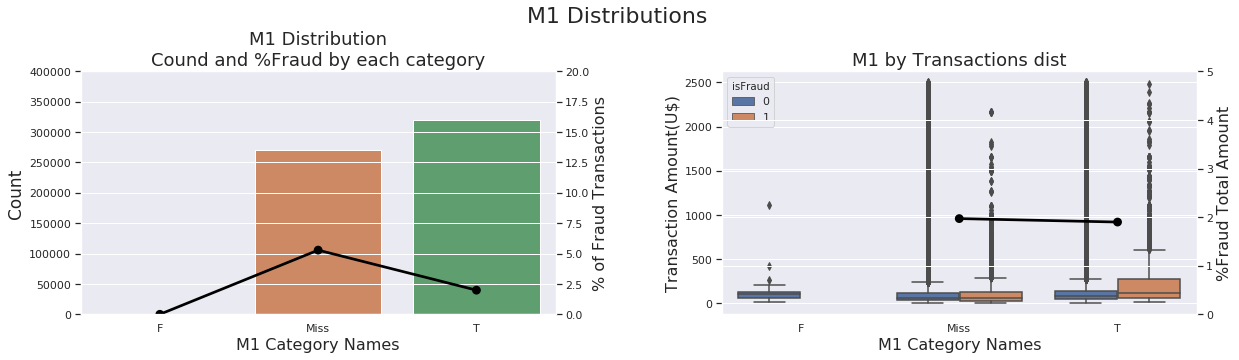

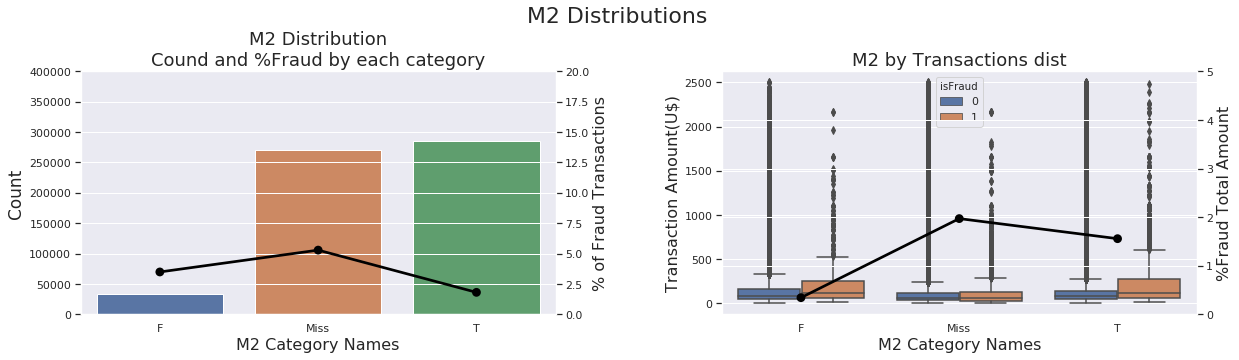

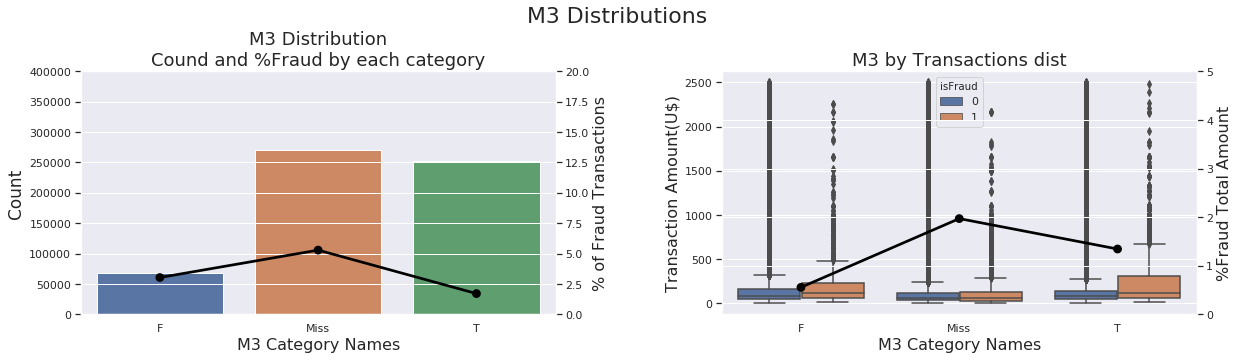

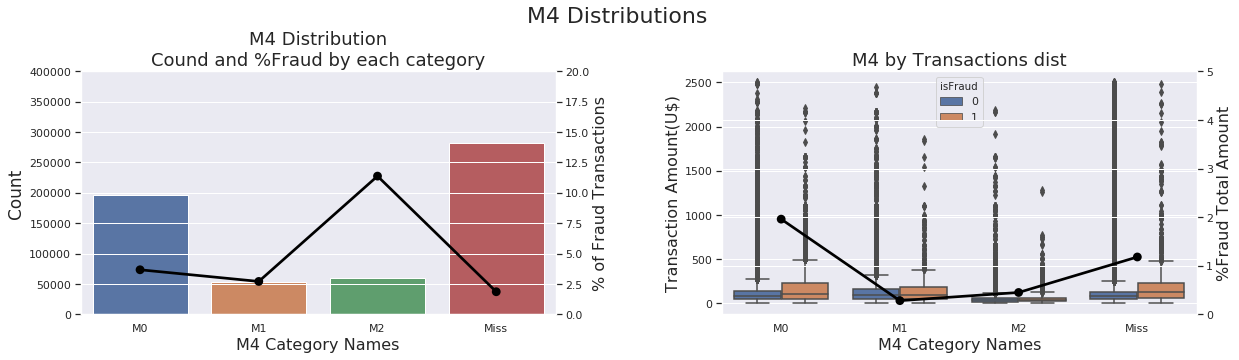

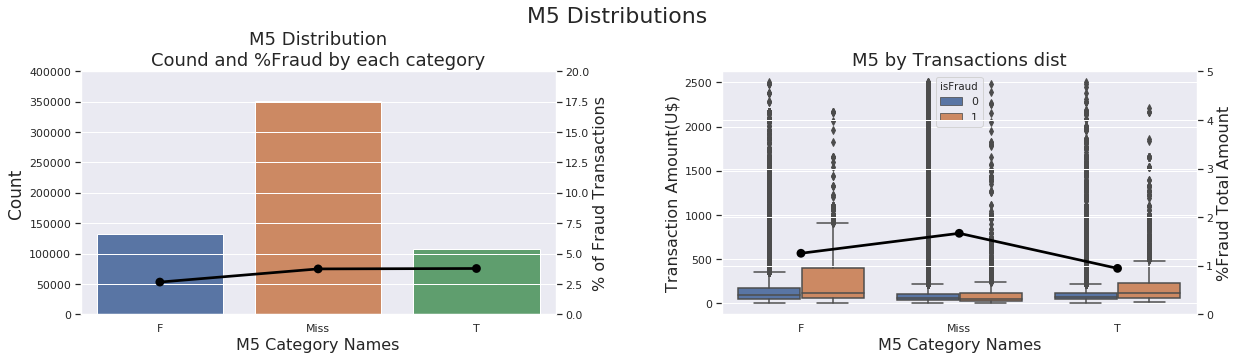

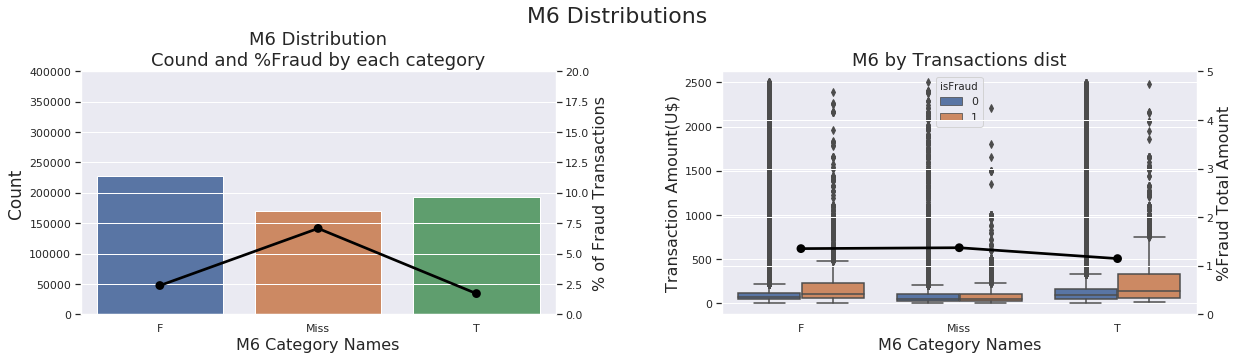

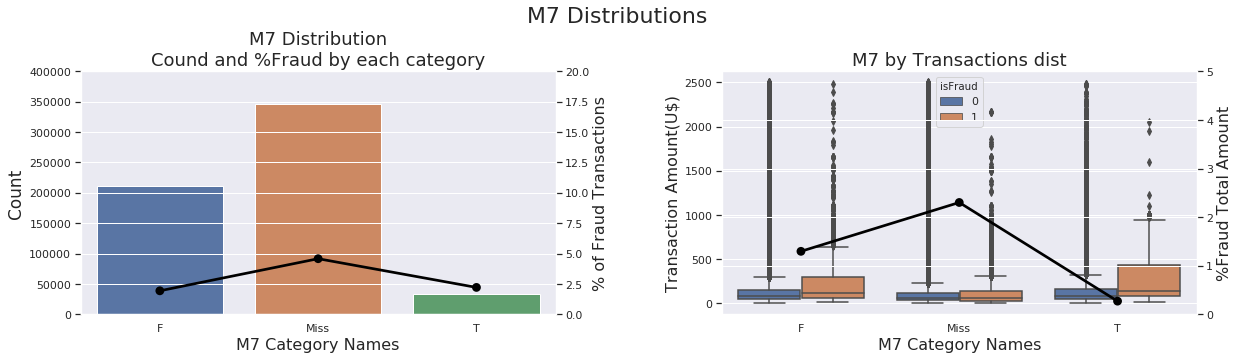

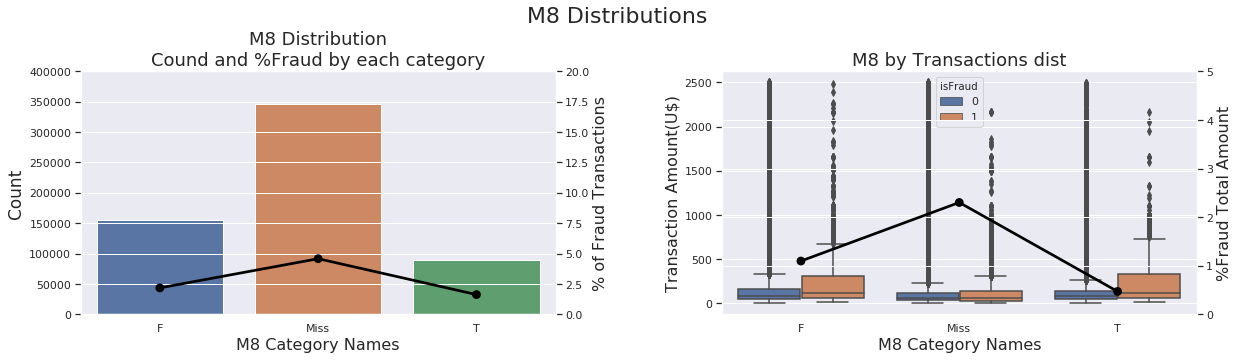

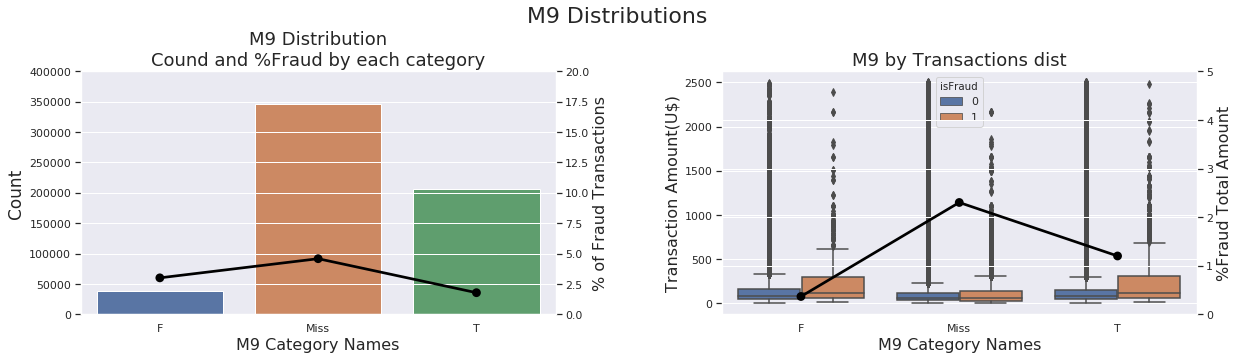

In [0]:
for columns in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    ploting_dist_ratio(train_transaction, columns, lim=2500)

Addr1 Distributions

In [0]:
train_transaction.loc[train_transaction.addr1.isin(
    train_transaction.addr1.value_counts()[
        train_transaction.addr1.value_counts() <= 5000 ].index), 'addr1'] = "Others"
train_transaction.loc[train_transaction.addr2.isin(
    train_transaction.addr2.value_counts()[
        train_transaction.addr2.value_counts() <= 50 ].index), 'addr2'] = "Others"

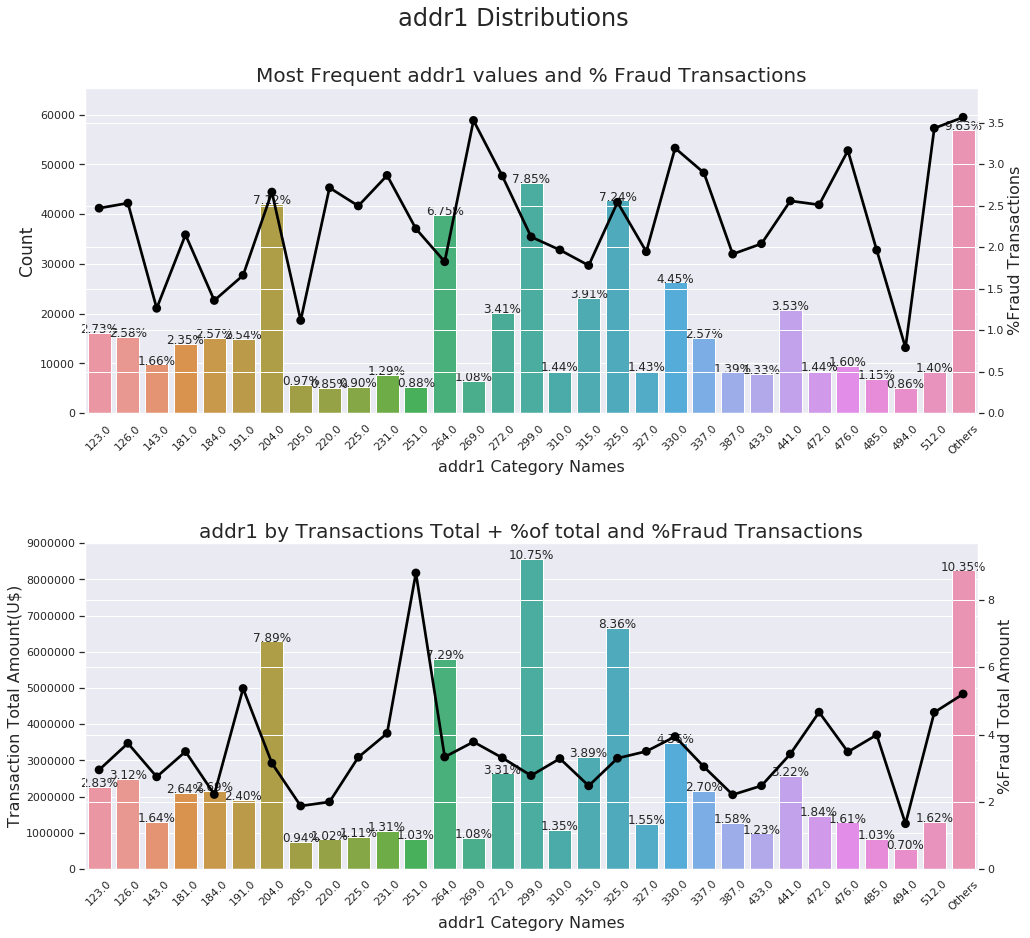

In [0]:
def ploting_cnt_amt(DataFile, Column, lim=2000):
    tmp = pd.crosstab(DataFile[Column], DataFile['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
    plt.suptitle(f'{Column} Distributions ', fontsize=24)
    
    plt.subplot(211)
    plot_1 = sns.countplot(x=Column,data=DataFile,order=list(tmp[Column].values))
    plot_1_2 = plot_1.twinx()
    plot_1_2 = sns.pointplot(x=Column, y='Fraud', data=tmp, order=list(tmp[Column].values),
                       color='black', legend=False)
    plot_1_2.set_ylim(0,tmp['Fraud'].max()*1.1)
    plot_1_2.set_ylabel("%Fraud Transactions", fontsize=16)
    plot_1.set_title(f"Most Frequent {Column} values and % Fraud Transactions", fontsize=20)
    plot_1.set_xlabel(f"{Column} Category Names", fontsize=16)
    plot_1.set_ylabel("Count", fontsize=17)
    plot_1.set_xticklabels(plot_1.get_xticklabels(),rotation=45)
    sizes = []
    for p in plot_1.patches:
        height = p.get_height()
        sizes.append(height)
        plot_1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12) 
        
    plot_1.set_ylim(0,max(sizes)*1.15)
    
    #########################################################################
    perc_amt = (DataFile.groupby(['isFraud',Column])['TransactionAmt'].sum() \
                / DataFile.groupby([Column])['TransactionAmt'].sum() * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    amt = DataFile.groupby([Column])['TransactionAmt'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)
    plt.subplot(212)
    plot_2 = sns.barplot(x=Column, y='TransactionAmt', 
                       data=amt, 
                       order=list(tmp[Column].values))
    plot_2_2 = plot_2.twinx()
    plot_2_2 = sns.pointplot(x=Column, y='Fraud', data=perc_amt, 
                        order=list(tmp[Column].values),
                       color='black', legend=False, )
    plot_2_2.set_ylim(0,perc_amt['Fraud'].max()*1.1)
    plot_2_2.set_ylabel("%Fraud Total Amount", fontsize=16)
    plot_2.set_xticklabels(plot_2.get_xticklabels(),rotation=45)
    plot_2.set_title(f"{Column} by Transactions Total + %of total and %Fraud Transactions", fontsize=20)
    plot_2.set_xlabel(f"{Column} Category Names", fontsize=16)
    plot_2.set_ylabel("Transaction Total Amount(U$)", fontsize=16)
    plot_2.set_xticklabels(plot_2.get_xticklabels(),rotation=45)    
    
    for p in plot_2.patches:
        height = p.get_height()
        plot_2.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total_amt*100),
                ha="center",fontsize=12) 
        
    plt.subplots_adjust(hspace=.4, top = 0.9)
    plt.show()
    
ploting_cnt_amt(train_transaction, 'addr1')

ADDR2 Distributions

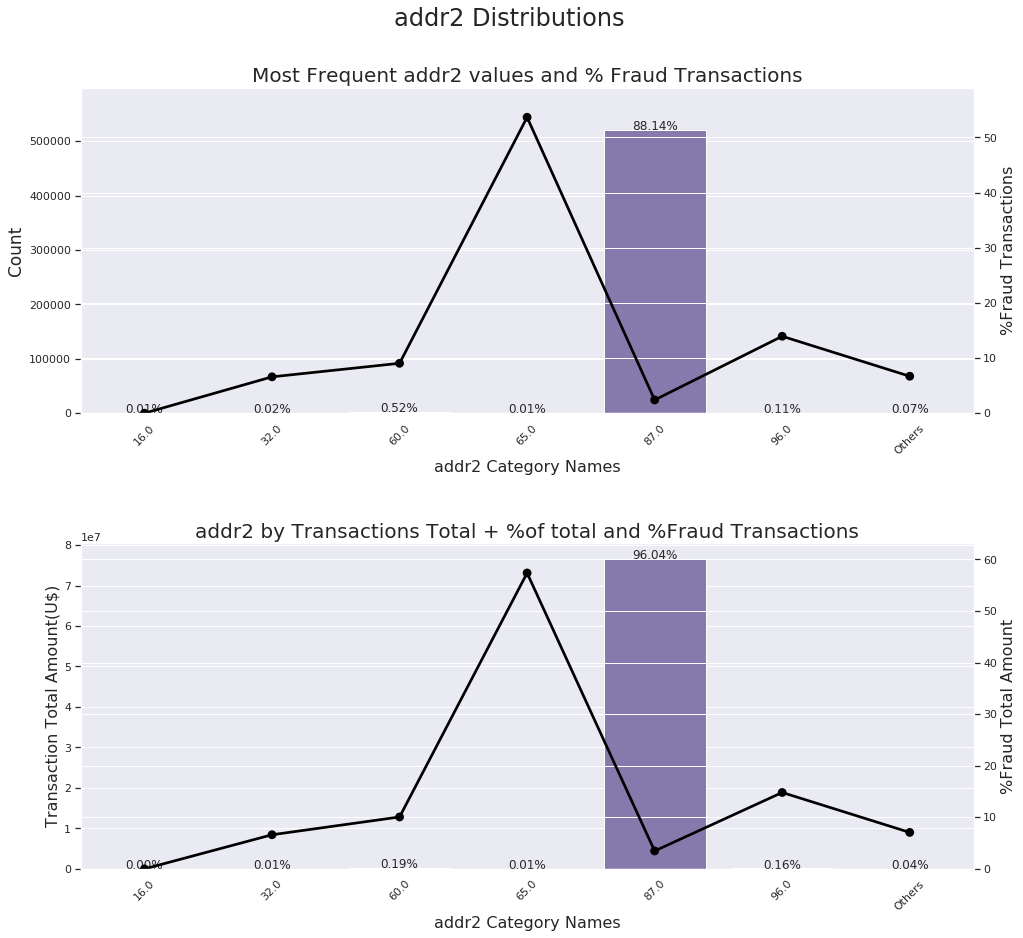

In [0]:
ploting_cnt_amt(train_transaction, 'addr2')

Ploting P-Email Domain

In [0]:
train_transaction.loc[train_transaction['P_emaildomain'].isin(['gmail.com', 'gmail']),'P_emaildomain'] = 'Google'

train_transaction.loc[train_transaction['P_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                         'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                         'yahoo.es']), 'P_emaildomain'] = 'Yahoo Mail'
train_transaction.loc[train_transaction['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'
train_transaction.loc[train_transaction.P_emaildomain.isin(train_transaction.P_emaildomain\
                                         .value_counts()[train_transaction.P_emaildomain.value_counts() <= 500 ]\
                                         .index), 'P_emaildomain'] = "Others"
train_transaction.P_emaildomain.fillna("NoInf", inplace=True)

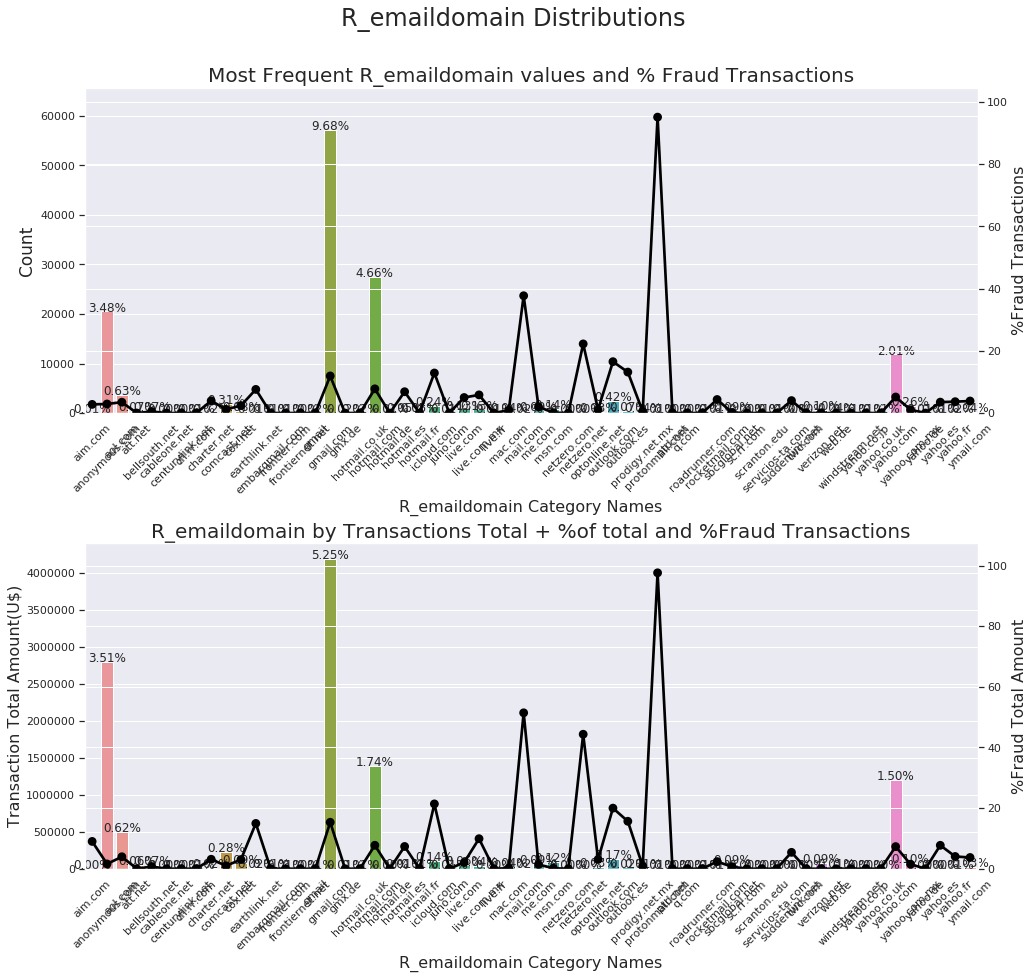

In [0]:
ploting_cnt_amt(train_transaction, 'R_emaildomain')

Exploring C1-C14 features

In [0]:
train_transaction.loc[train_transaction.C1.isin(
    train_transaction.C1.value_counts()[
        train_transaction.C1.value_counts() <= 400 ].index), 'C1'] = "Others"

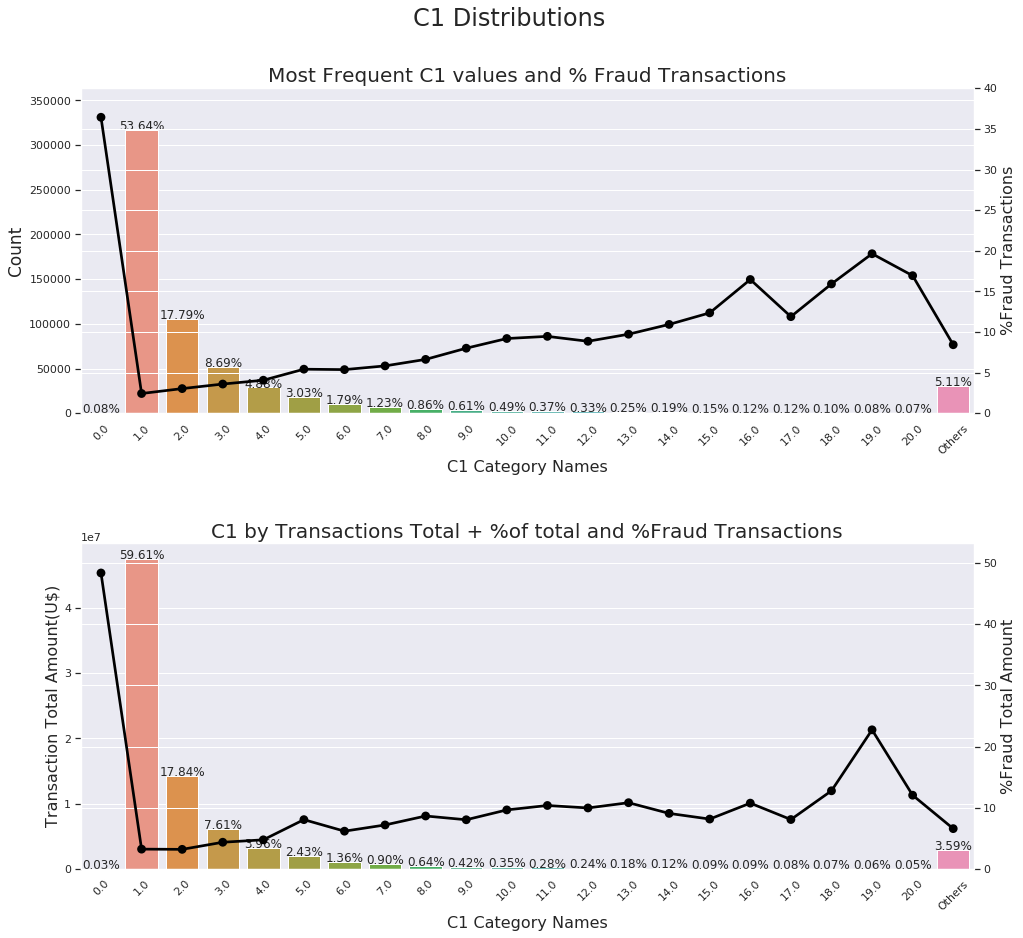

In [0]:
ploting_cnt_amt(train_transaction, 'C1')

TimeDelta Feature to check if frauds have some specific hour that has **highest % of frauds**

In [0]:
# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100400#latest-579480
import datetime

START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train_transaction["Date"] = train_transaction['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
train_transaction['_Weekdays'] = train_transaction['Date'].dt.dayofweek
train_transaction['_Hours'] = train_transaction['Date'].dt.hour
train_transaction['_Days'] = train_transaction['Date'].dt.day

test_transaction["Date"] = test_transaction['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
test_transaction['_Weekdays'] = test_transaction['Date'].dt.dayofweek
test_transaction['_Hours'] = test_transaction['Date'].dt.hour
test_transaction['_Days'] = test_transaction['Date'].dt.day

Top Days with highest Total Transaction Amount

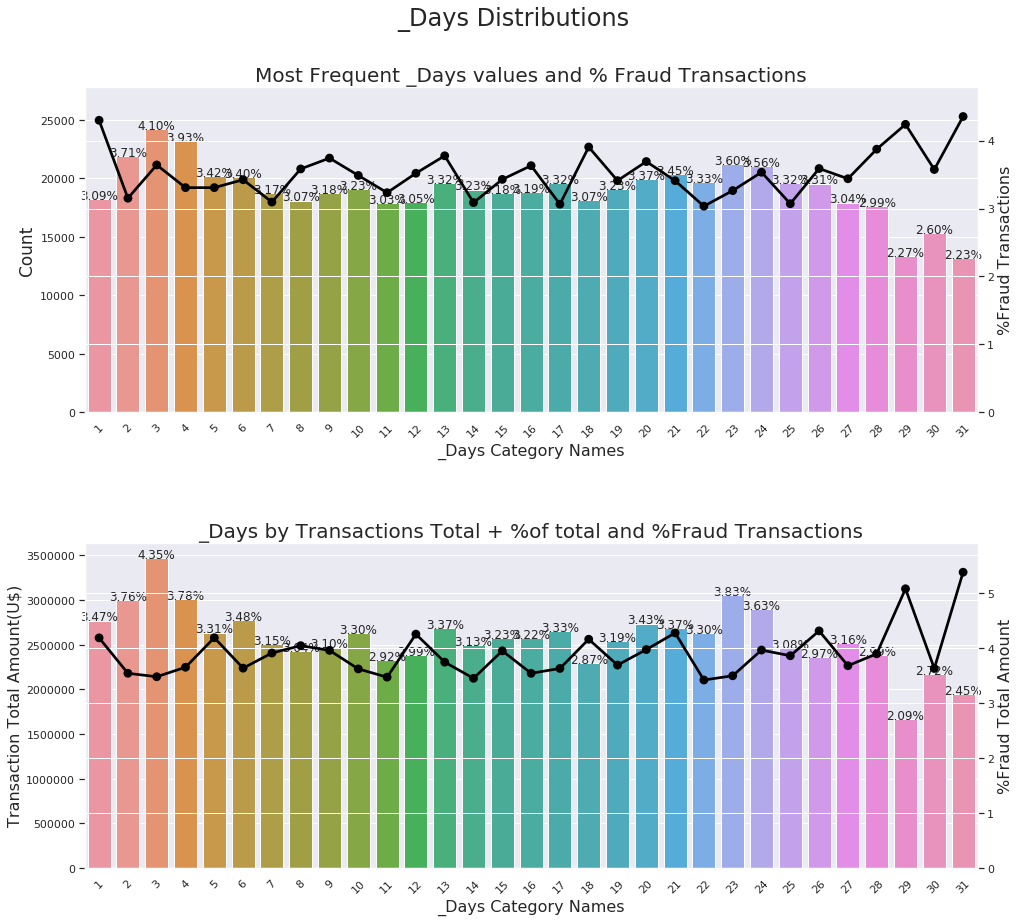

In [0]:
ploting_cnt_amt(train_transaction, '_Days')

Ploting WeekDays Distributions

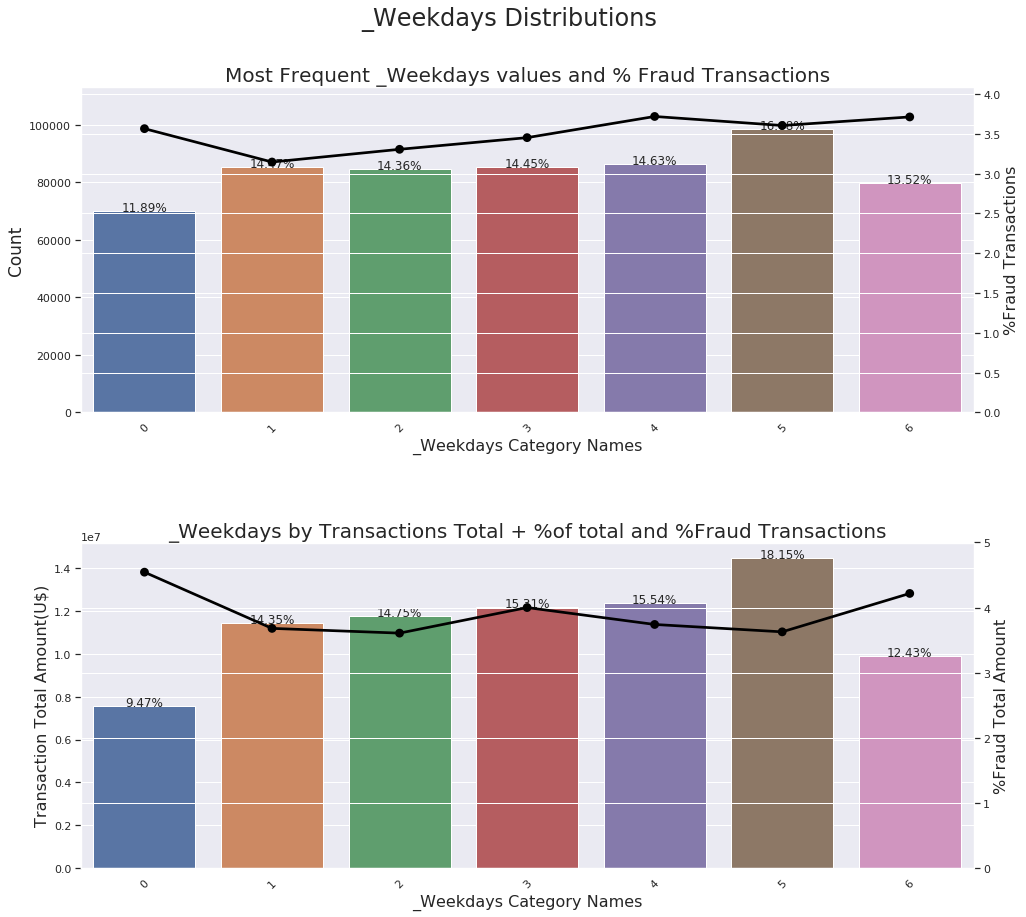

In [0]:
ploting_cnt_amt(train_transaction, '_Weekdays')

Ploting Hours Distributions

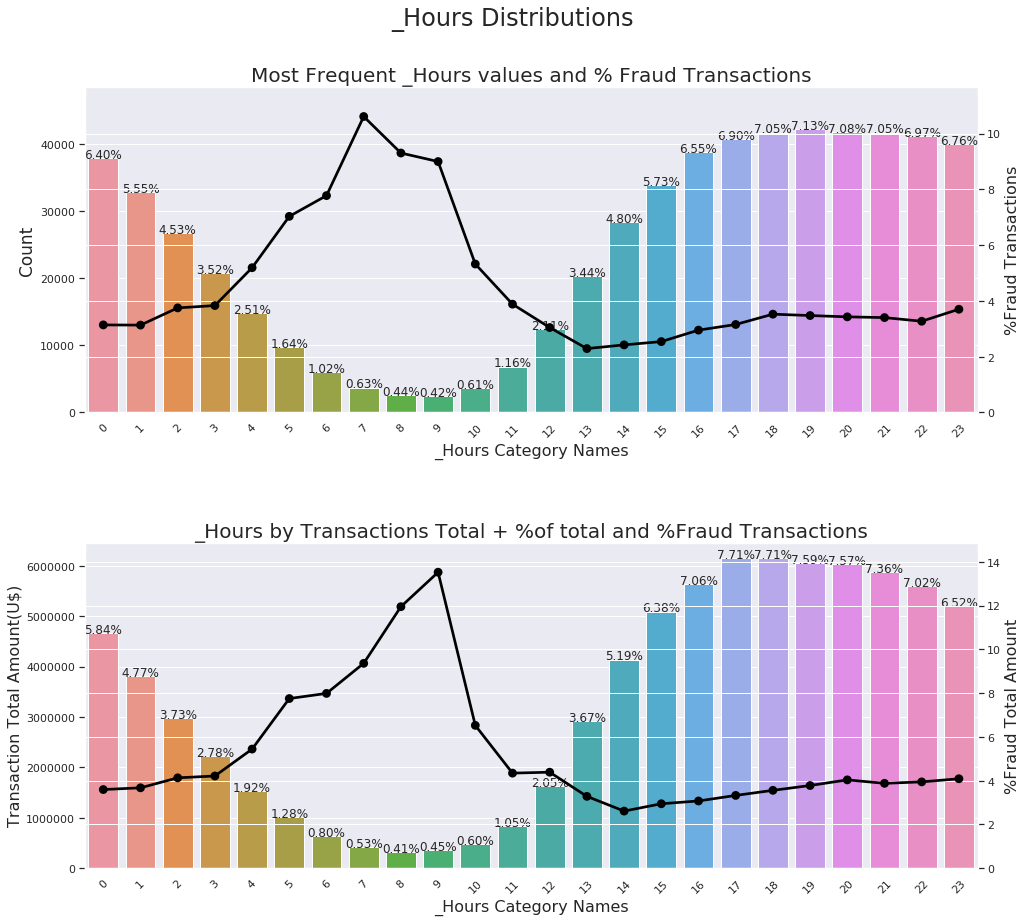

In [0]:
ploting_cnt_amt(train_transaction, '_Hours')

Transactions and Total Amount per day

In [0]:
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff
# Calling the function to transform the date column in datetime pandas object

#seting some static color options
color_op = ['#5527A0', '#BB93D7', '#834CF7', '#6C941E', '#93EAEA', '#7425FF', '#F2098A', '#7E87AC', 
            '#EBE36F', '#7FD394', '#49C35D', '#3058EE', '#44FDCF', '#A38F85', '#C4CEE0', '#B63A05', 
            '#4856BF', '#F0DB1B', '#9FDBD9', '#B123AC']


dates_temp = train_transaction.groupby(train_transaction.Date.dt.date)['TransactionAmt'].count().reset_index()
# renaming the columns to apropriate names

# creating the first trace with the necessary parameters
trace = go.Scatter(x=dates_temp['Date'], y=dates_temp.TransactionAmt,
                    opacity = 0.8, line = dict(color = color_op[7]), name= 'Total Transactions')

# Below we will get the total amount sold
dates_temp_sum = train_transaction.groupby(train_transaction.Date.dt.date)['TransactionAmt'].sum().reset_index()

# using the new dates_temp_sum we will create the second trace
trace1 = go.Scatter(x=dates_temp_sum.Date, line = dict(color = color_op[1]), name="Total Amount",
                        y=dates_temp_sum['TransactionAmt'], opacity = 0.8, yaxis='y2')

#creating the layout the will allow us to give an title and 
# give us some interesting options to handle with the outputs of graphs
layout = dict(
    title= "Total Transactions and Fraud Informations by Date",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=3, label='3m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible = True),
        type='date' ),
    yaxis=dict(title='Total Transactions'),
    yaxis2=dict(overlaying='y',
                anchor='x', side='right',
                zeroline=False, showgrid=False,
                title='Total Transaction Amount')
)

# creating figure with the both traces and layout
fig = dict(data= [trace, trace1,], layout=layout)

#rendering the graphs
iplot(fig) #it's an equivalent to plt.show()

Fraud Transactions by Date

In [0]:
# Calling the function to transform the date column in datetime pandas object

#seting some static color options
color_op = ['#5527A0', '#BB93D7', '#834CF7', '#6C941E', '#93EAEA', '#7425FF', '#F2098A', '#7E87AC', 
            '#EBE36F', '#7FD394', '#49C35D', '#3058EE', '#44FDCF', '#A38F85', '#C4CEE0', '#B63A05', 
            '#4856BF', '#F0DB1B', '#9FDBD9', '#B123AC']

tmp_amt = train_transaction.groupby([train_transaction.Date.dt.date, 'isFraud'])['TransactionAmt'].sum().reset_index()
tmp_trans = train_transaction.groupby([train_transaction.Date.dt.date, 'isFraud'])['TransactionAmt'].count().reset_index()

tmp_trans_fraud = tmp_trans[tmp_trans['isFraud'] == 1]
tmp_amt_fraud = tmp_amt[tmp_amt['isFraud'] == 1]

dates_temp = train_transaction.groupby(train_transaction.Date.dt.date)['TransactionAmt'].count().reset_index()
# renaming the columns to apropriate names

# creating the first trace with the necessary parameters
trace = go.Scatter(x=tmp_trans_fraud['Date'], y=tmp_trans_fraud.TransactionAmt,
                    opacity = 0.8, line = dict(color = color_op[1]), name= 'Fraud Transactions')

# using the new dates_temp_sum we will create the second trace
trace1 = go.Scatter(x=tmp_amt_fraud.Date, line = dict(color = color_op[7]), name="Fraud Amount",
                    y=tmp_amt_fraud['TransactionAmt'], opacity = 0.8, yaxis='y2')

#creating the layout the will allow us to give an title and 
# give us some interesting options to handle with the outputs of graphs
layout = dict(
    title= "FRAUD TRANSACTIONS - Total Transactions and Fraud Informations by Date",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=3, label='3m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible = True),
        type='date' ),
    yaxis=dict(title='Total Transactions'),
    yaxis2=dict(overlaying='y',
                anchor='x', side='right',
                zeroline=False, showgrid=False,
                title='Total Transaction Amount')
)

# creating figure with the both traces and layout
fig = dict(data= [trace, trace1], layout=layout)

#rendering the graphs
iplot(fig) #it's an equivalent to plt.show()

# Feature extraction

Credits to Konstantin's Kernel
- IEEE Data Minification: https://www.kaggle.com/kernels/svzip/18870049 
- IEEE - GB-2: https://www.kaggle.com/kyakovlev/ieee-gb-2-make-amount-useful-again 

In [0]:
import random, os
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [0]:
SEED = 42
seed_everything(SEED)
LOCAL_TEST = True
TARGET = 'isFraud'

In [0]:
train_transaction.to_pickle('ieee-fraud-detection/train_transaction.pkl')
train_identity.to_pickle('ieee-fraud-detection/train_identity.pkl')
test_transaction.to_pickle('ieee-fraud-detection/test_transaction.pkl')
test_identity.to_pickle('ieee-fraud-detection/test_identity.pkl')

In [0]:
train_df = pd.read_pickle('ieee-fraud-detection/train_transaction.pkl')

if LOCAL_TEST:
    test_df = train_df.iloc[-100000:,].reset_index(drop=True)
    train_df = train_df.iloc[:400000,].reset_index(drop=True)
    
    train_identity = pd.read_pickle('ieee-fraud-detection/train_identity.pkl')
    test_identity  = train_identity[train_identity['TransactionID'].isin(test_df['TransactionID'])].reset_index(drop=True)
    train_identity = train_identity[train_identity['TransactionID'].isin(train_df['TransactionID'])].reset_index(drop=True)
else:
    test_df = pd.read_pickle('ieee-fraud-detection/test_transaction.pkl')
    test_identity = pd.read_pickle('ieee-fraud-detection/test_identity.pkl')

In [0]:
valid_card = train_df['card1'].value_counts()
valid_card = valid_card[valid_card>10]
valid_card = list(valid_card.index)
    
train_df['card1'] = np.where(train_df['card1'].isin(valid_card), train_df['card1'], np.nan)
test_df['card1']  = np.where(test_df['card1'].isin(valid_card), test_df['card1'], np.nan)

In [0]:
i_cols = ['card1','card2','card3','card5',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'D1','D2','D3','D4','D5','D6','D7','D8','D9',
          'addr1','addr2',
          'dist1','dist2',
          'P_emaildomain', 'R_emaildomain'
         ]

for col in i_cols:
    temp_df = pd.concat([train_df[[col]], test_df[[col]]])
    fq_encode = temp_df[col].value_counts().to_dict()   
    train_df[col+'_fq_enc'] = train_df[col].map(fq_encode)
    test_df[col+'_fq_enc']  = test_df[col].map(fq_encode)

In [0]:
for col in ['ProductCD','M4']:
    temp_dict = train_df.groupby([col])[TARGET].agg(['mean']).reset_index().rename(
                                                        columns={'mean': col+'_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col+'_target_mean'].to_dict()

    train_df[col+'_target_mean'] = train_df[col].map(temp_dict)
    test_df[col+'_target_mean']  = test_df[col].map(temp_dict)

In [0]:
for col in list(train_df):
    if train_df[col].dtype=='O':
        print(col)
        train_df[col] = train_df[col].fillna('unseen_before_label')
        test_df[col]  = test_df[col].fillna('unseen_before_label')
        
        train_df[col] = train_df[col].astype(str)
        test_df[col] = test_df[col].astype(str)
        
        le = LabelEncoder()
        le.fit(list(train_df[col])+list(test_df[col]))
        train_df[col] = le.transform(train_df[col])
        test_df[col]  = le.transform(test_df[col])
        
        train_df[col] = train_df[col].astype('category')
        test_df[col] = test_df[col].astype('category')

ProductCD
card3
card4
card5
card6
addr1
addr2
P_emaildomain
R_emaildomain
C1
M1
M2
M3
M4
M5
M6
M7
M8
M9


In [0]:
train_df['uid'] = train_df['card1'].astype(str)+'_'+train_df['card2'].astype(str)+'_'+train_df['card3'].astype(str)+'_'+train_df['card4'].astype(str)
test_df['uid'] = test_df['card1'].astype(str)+'_'+test_df['card2'].astype(str)+'_'+test_df['card3'].astype(str)+'_'+test_df['card4'].astype(str)

train_df['uid2'] = train_df['uid'].astype(str)+'_'+train_df['addr1'].astype(str)+'_'+train_df['addr2'].astype(str)
test_df['uid2'] = test_df['uid'].astype(str)+'_'+test_df['addr1'].astype(str)+'_'+test_df['addr2'].astype(str)

valid_card = train_df['TransactionAmt'].value_counts()
valid_card = valid_card[valid_card>10]
valid_card = list(valid_card.index)
    
train_df['TransactionAmt_check'] = np.where(train_df['TransactionAmt'].isin(test_df['TransactionAmt']), 1, 0)
test_df['TransactionAmt_check']  = np.where(test_df['TransactionAmt'].isin(train_df['TransactionAmt']), 1, 0)

i_cols = ['card1','card2','card3','card5','uid','uid2']

for col in i_cols:
    for agg_type in ['mean', 'std']:
        new_col_name = col+'_TransactionAmt_'+agg_type
        temp_df = pd.concat([train_df[[col, 'TransactionAmt']], test_df[[col,'TransactionAmt']]])
        temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})
        
        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   
    
        train_df[new_col_name] = train_df[col].map(temp_df)
        test_df[new_col_name]  = test_df[col].map(temp_df)

In [0]:
train_df['bank_type'] = train_df['card3'].astype(str)+'_'+train_df['card5'].astype(str)
test_df['bank_type']  = test_df['card3'].astype(str)+'_'+test_df['card5'].astype(str)

train_df['address_match'] = train_df['bank_type'].astype(str)+'_'+train_df['addr2'].astype(str)
test_df['address_match']  = test_df['bank_type'].astype(str)+'_'+test_df['addr2'].astype(str)

for col in ['address_match','bank_type']:
    temp_df = pd.concat([train_df[[col]], test_df[[col]]])
    temp_df[col] = np.where(temp_df[col].str.contains('nan'), np.nan, temp_df[col])
    temp_df = temp_df.dropna()
    fq_encode = temp_df[col].value_counts().to_dict()   
    train_df[col] = train_df[col].map(fq_encode)
    test_df[col]  = test_df[col].map(fq_encode)

train_df['address_match'] = train_df['address_match']/train_df['bank_type'] 
test_df['address_match']  = test_df['address_match']/test_df['bank_type']

In [0]:
rm_cols = ['TransactionID','TransactionDT', TARGET, 'uid', 'uid2', 'bank_type']
features_columns = list(train_df)
for col in rm_cols:
    if col in features_columns:
        features_columns.remove(col)

In [0]:
# Only use these features in the dataset
numerical_features = df_train.columns
# ['id_01', 'id_02', 'id_03', 'id_04', 'id_05 ',
#                       'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 
#                       'id_11','id_13', 'id_14', 'id_17', 'id_18', 
#                       'id_19', 
#                       'C1', 'C2', 'C3']
# 'addr1', 'addr2', 'dist1', 'dist2',

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['TransactionDT', 'TransactionAmt', 'ProductCD', 
                        'P_emaildomain', 'R_emaildomain', 
                        'DeviceType', 'card4']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline
# Now we have a full prediction pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', LogisticRegression(C=1e5))])
              

# target variable which we would like to predict, is the 'isFraud' variable
target = 'isFraud'



## Light GBM Model

In [0]:
lgb_params = {
  'objective':'binary',
  'boosting_type':'gbdt',
  'metric':'auc',
  'n_jobs':-1,
  'learning_rate':0.064,
  'num_leaves': 2**8,
  'max_depth':-1,
  'tree_learner':'serial',
  'colsample_bytree': 0.85,
  'subsample_freq':1,
  'subsample':0.85,
  'n_estimators':2**9,
  'max_bin':255,
  'verbose':-1,
  'seed': SEED,
  'early_stopping_rounds':100,
  'reg_alpha':0.3,
  'reg_lamdba':0.243
}

In [0]:
import lightgbm as lgb

def make_predictions(tr_df, tt_df, features_columns, target, lgb_params, NFOLDS=2):
    folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

    X,y = tr_df[features_columns], tr_df[target]    
    P,P_y = tt_df[features_columns], tt_df[target]  

    tt_df = tt_df[['TransactionID',target]]    
    predictions = np.zeros(len(tt_df))
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
        print('Fold:',fold_)
        tr_x, tr_y = X.iloc[trn_idx,:], y[trn_idx]
        vl_x, vl_y = X.iloc[val_idx,:], y[val_idx]
            
        print(len(tr_x),len(vl_x))
        tr_data = lgb.Dataset(tr_x, label=tr_y)

        if LOCAL_TEST:
            vl_data = lgb.Dataset(P, label=P_y) 
        else:
            vl_data = lgb.Dataset(vl_x, label=vl_y)  

        estimator = lgb.train(
            lgb_params,
            tr_data,
            valid_sets = [tr_data, vl_data],
            verbose_eval = 200,
        )   
        
        pp_p = estimator.predict(P)
        predictions += pp_p/NFOLDS

        if LOCAL_TEST:
            feature_imp = pd.DataFrame(sorted(zip(estimator.feature_importance(),X.columns)), columns=['Value','Feature'])
            print(feature_imp)
        
        del tr_x, tr_y, vl_x, vl_y, tr_data, vl_data
        gc.collect()
        
    tt_df['prediction'] = predictions
    
    return tt_df

In [0]:
if LOCAL_TEST:
    test_predictions = make_predictions(train_df, test_df, features_columns, TARGET, lgb_params)
    print(metrics.roc_auc_score(test_predictions[TARGET], test_predictions['prediction']))
else:
    lgb_params['learning_rate'] = 0.005
    lgb_params['n_estimators'] = 2000
    lgb_params['early_stopping_rounds'] = 100    
    test_predictions = make_predictions(train_df, test_df, features_columns, TARGET, lgb_params, NFOLDS=10)

KeyError: ignored